Устанавливаем библиотеки BeautifulSoup и request для парсинга

In [ ]:
!pip install beautifulsoup4

In [ ]:
from bs4 import BeautifulSoup
import requests
import csv

## **Задание №1 - №2**

Производится парсинг первых 50 страниц сайта https://www.restoran.ru/msk/opinions/, отбираемые данные:

название ресторана (restaurants),  

дата отзыва (dates),

отзыв (reviews),

оценка (scores).

In [ ]:
def scrape_restaurant_reviews(num_pages):
    restaurant_names = []
    review_dates = []
    review_scores = []
    review_texts = []

    for page_num in range(1, num_pages + 1):
        url = f'https://www.restoran.ru/msk/opinions/?PAGEN_1={page_num}'
        response = requests.get(url)
        soup = BeautifulSoup(response.text, 'html.parser')

        restaurants = soup.find_all('div', class_='place-name-wrap')
        dates = soup.find_all('div', class_='review-date')
        scores = soup.find_all('div', class_='place-rating')
        reviews = soup.find_all('span', class_='review-text-preview')

        for restaurant in restaurants:
            restaurant_name = ''.join(char for char in str(restaurant.text) if char.isalpha())
            restaurant_names.append(restaurant_name)

        review_dates.extend(date.text for date in dates)
        review_scores.extend(int(str(score.text)[0]) for score in scores)
        review_texts.extend(review.text for review in reviews)

    return restaurant_names, review_dates, review_scores, review_texts

n = 50
restaurants_all, dates_all, score_all, reviews_all = scrape_restaurant_reviews(n)


Записываем данные результата парсинга в CSV

In [ ]:
with open("dataset.csv", mode="w", encoding='utf-8-sig') as w_file:
    file_writer = csv.writer(w_file, delimiter=',', lineterminator="\r")
    file_writer.writerow(["Restaurant", "Review Date", "Review", "Scope"])
    for i in range(len(restaurants_all)):
        file_writer.writerow(
            [i, restaurants_all[i], dates_all[i], reviews_all[i], score_all[i]])



## **Задание №3**

In [ ]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

In [ ]:
df = pd.read_csv('dataset.csv', index_col=0)

In [ ]:
df.head()

,Restaurant,Review Date,Review,Scope
0,РесторанLALALANDЛаЛаЛэнд,22 сентября 2023,Ударились в 90-е? Ну что вы придумали? Покажит...,4.0
1,РесторанУрожайиминиотель,21 сентября 2023,"В ресторане ""Урожай"" очень уютно. Он оформлен ...",5.0
2,РесторанWillTaste,20 сентября 2023,Вкусно,NaN
Быстро и безумно комфортно,4,NaN,NaN,NaN
3,РесторанBAMBOOBAR,20 сентября 2023,Приезжала в гости к друзьям в Москве и первым ...,4.0


Топ-5 ресторанов по кол-ву отзывов.

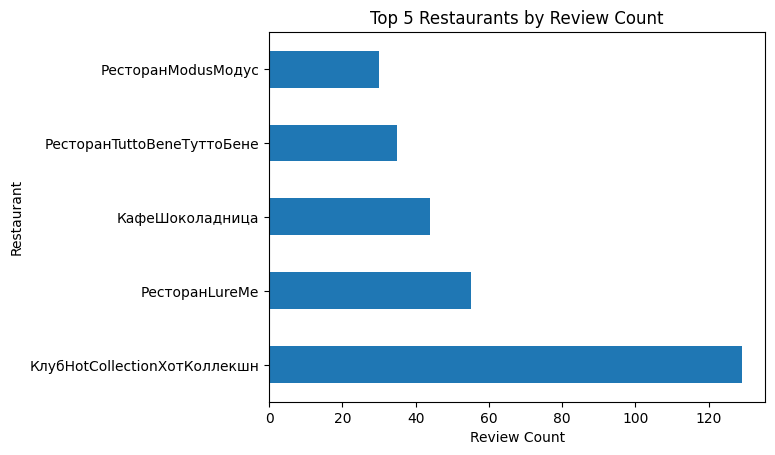

In [ ]:
top_restaurants = df['Restaurant'].value_counts(ascending=False).head(5)
ax = top_restaurants.plot(kind='barh')
ax.set_xscale("linear")
plt.xlabel('Review Count')
plt.ylabel('Restaurant')
plt.title('Top 5 Restaurants by Review Count')
plt.show()

Топ-5 ресторанов с самой высокой средней оценкой

In [ ]:
top_restaurants_by_score = df.groupby(['Restaurant'])['Scope'].mean().sort_values(ascending=False).head(5)

top_restaurants_by_score

Restaurant
БанкетныйзалChaletШале                   5.0
РесторанCafeImperial                     5.0
РесторанLureMe                           5.0
РесторанLaDeliziaЛаДелиция               5.0
РесторанJoonAsiainRestaurantBarзакрыт    5.0
Name: Scope, dtype: float64

Распределение по количеству оценок:

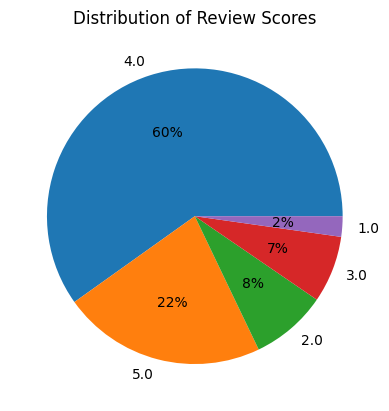

In [ ]:
score_counts = df['Scope'].value_counts(ascending=False)
score_counts.plot(kind='pie', autopct='%1.0f%%')
plt.title('Distribution of Review Scores')
plt.ylabel('')
plt.show()

Класс 4 оказался мажоритарным, в то время как классы 1, 2 и 3 - миноритарными

## **Задание №4**

Сбалансированная выборка:

In [ ]:
class_1_data = df[df['Scope'] == 1]
class_2_data = df[df['Scope'] == 2]
class_3_data = df[df['Scope'] == 3]
class_4_data = df[df['Scope'] == 4]
class_5_data = df[df['Scope'] == 5]

min_class_length = len(class_5_data)

undersampled_class_4_data = class_4_data.sample(n=min_class_length, replace=True, random_state=42)
undersampled_class_5_data = class_5_data.sample(n=min_class_length, replace=True, random_state=42)

oversampled_class_1_data = class_1_data.sample(n=min_class_length, replace=True, random_state=42)
oversampled_class_2_data = class_2_data.sample(n=min_class_length, replace=True, random_state=42)
oversampled_class_3_data = class_3_data.sample(n=min_class_length, replace=True, random_state=42)

balanced_df = pd.concat([oversampled_class_1_data, oversampled_class_2_data, oversampled_class_3_data,
                         undersampled_class_4_data, undersampled_class_5_data])




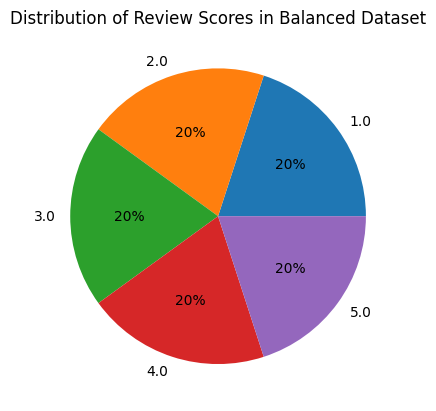

In [ ]:
score_distribution = balanced_df['Scope'].value_counts(ascending=False)
score_distribution.plot(kind='pie', autopct='%1.0f%%')
plt.title('Distribution of Review Scores in Balanced Dataset')
plt.ylabel('')
plt.show()


In [ ]:
balanced_df.drop(columns=["Restaurant", "Review Date"], inplace=True)




## **Задание №5**

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.linear_model import SGDClassifier
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier

X_train_text, X_test_text, y_train_labels, y_test_labels = train_test_split(balanced_df['Review'], balanced_df['Scope'], test_size=0.2, random_state=42)

tfidf_vectorizer = TfidfVectorizer(max_features=10000)

X_train_tfidf = tfidf_vectorizer.fit_transform(X_train_text)
X_test_tfidf = tfidf_vectorizer.transform(X_test_text)


In [ ]:
itog = {}

**Логистическая регрессия**

In [ ]:
%%time
logistic_regression_classifier = LogisticRegression()

logistic_regression_classifier.fit(X_train_tfidf, y_train_labels)

y_pred_labels = logistic_regression_classifier.predict(X_test_tfidf)

accuracy = accuracy_score(y_test_labels, y_pred_labels)

itog['LogisticRegression'] = round(accuracy, 2)


CPU times: user 191 ms, sys: 202 ms, total: 393 ms
Wall time: 235 ms


In [ ]:
from sklearn.metrics import confusion_matrix
import pandas as pd

y_test_labels = pd.Series(y_test_labels, name='Actual').reset_index(drop=True)
y_pred_labels = pd.Series(y_pred_labels, name='Predicted')
confusion_matrix_df = pd.crosstab(y_test_labels, y_pred_labels)

print(confusion_matrix_df)


Predicted  1.0  2.0  3.0  4.0  5.0
Actual                            
1.0         46    0    0    0    0
2.0          0   42    0    5    0
3.0          0    0   42    4    0
4.0          0    3    0   25    7
5.0          0    1    0    9   35


**Метод N ближайших соседей**

In [ ]:
%%time
k_neighbors_classifier = KNeighborsClassifier()

k_neighbors_classifier.fit(X_train_tfidf, y_train_labels)

y_pred_labels = k_neighbors_classifier.predict(X_test_tfidf)

accuracy = accuracy_score(y_test_labels, y_pred_labels)
print("Accuracy:", accuracy)

itog['KNeighborsClassifier'] = round(accuracy, 2)


Accuracy: 0.6118721461187214
CPU times: user 324 ms, sys: 5.7 ms, total: 330 ms
Wall time: 294 ms


In [ ]:
actual_labels = pd.Series(y_test_labels, name='Actual').reset_index(drop=True)
predicted_labels = pd.Series(y_pred_labels, name='Predicted')
confusion_matrix_df = pd.crosstab(actual_labels, predicted_labels)

print(confusion_matrix_df)


Predicted  1.0  2.0  3.0  4.0  5.0
Actual                            
1.0         46    0    0    0    0
2.0          2   28    3   11    3
3.0          1    2   35    7    1
4.0          1    7   10    8    9
5.0          4    8    2   14   17


**SVC**

In [ ]:
%%time
support_vector_classifier = svm.SVC()

support_vector_classifier.fit(X_train_tfidf, y_train_labels)

y_pred_labels = support_vector_classifier.predict(X_test_tfidf)

accuracy = accuracy_score(y_test_labels, y_pred_labels)
print("Accuracy:", accuracy)

itog['SVC'] = round(accuracy, 2)


Accuracy: 0.8447488584474886
CPU times: user 281 ms, sys: 456 µs, total: 282 ms
Wall time: 302 ms


In [ ]:
actual_labels = pd.Series(y_test_labels, name='Actual').reset_index(drop=True)
predicted_labels = pd.Series(y_pred_labels, name='Predicted')
confusion_matrix_df = pd.crosstab(actual_labels, predicted_labels)

print(confusion_matrix_df)


Predicted  1.0  2.0  3.0  4.0  5.0
Actual                            
1.0         46    0    0    0    0
2.0          0   37    0   10    0
3.0          0    0   41    5    0
4.0          0    1    0   30    4
5.0          0    0    0   14   31


**Случайный Лес**


In [ ]:
%%time
random_forest_classifier = RandomForestClassifier()
random_forest_classifier.fit(X_train_tfidf, y_train_labels)

y_pred_labels = random_forest_classifier.predict(X_test_tfidf)
accuracy = accuracy_score(y_test_labels, y_pred_labels)
print("Accuracy:", accuracy)

itog['RandomForestClassifier'] = round(accuracy, 2)



Accuracy: 0.863013698630137
CPU times: user 792 ms, sys: 2.71 ms, total: 794 ms
Wall time: 870 ms


In [ ]:
actual_labels_series = pd.Series(y_test_labels, name='Actual').reset_index(drop=True)
predicted_labels_series = pd.Series(y_pred_labels, name='Predicted')
confusion_matrix_df = pd.crosstab(actual_labels_series, predicted_labels_series)

print(confusion_matrix_df)


Predicted  1.0  2.0  3.0  4.0  5.0
Actual                            
1.0         46    0    0    0    0
2.0          0   42    0    2    3
3.0          0    2   41    3    0
4.0          0    2    1   27    5
5.0          0    1    1   10   33


Выводим точность каждой использованной модели.


**Наилучший показатель у метода SVC**

**Худший метод - N ближайших соседей**

In [ ]:
for key, value in itog.items():
  print(key, value)

LogisticRegression 0.87
KNeighborsClassifier 0.61
SVC 0.84
RandomForestClassifier 0.86


In [ ]:
from sklearn.metrics import classification_report
target_labels = ['1', '2', '3', '4', '5']
print(classification_report(actual_labels_series, predicted_labels_series, target_names=target_labels))


              precision    recall  f1-score   support

           1       1.00      1.00      1.00        46
           2       0.89      0.89      0.89        47
           3       0.95      0.89      0.92        46
           4       0.64      0.77      0.70        35
           5       0.80      0.73      0.77        45

    accuracy                           0.86       219
   macro avg       0.86      0.86      0.86       219
weighted avg       0.87      0.86      0.87       219



**Вывод**:

Для данной модели класс 1 наиболее оптимален, в то время как наихудшие результаты дают классы 4 и 5